In [67]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [68]:
df = pd.read_csv("./HeartDisease.csv")
df.head( )

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [69]:
#Seperating Features and Lables
X = df.drop("target",axis=1).values
y = df["target"].values
len(X),len(y)

(303, 303)

- The Dataset has continious feature value as Age, trestbps, thalach, chol,oldpeak
- The Dataset has Binary fature value features as sex, gbs, restecg, exang, target
- The Dataset has Categotrical features as cp, slope, ca, restecg,thal 

In [70]:
#One hote Encoding the Categorical Features
CategoricalFeatures = ["cp","slope","ca","restecg","thal"]
X = pd.get_dummies(df,columns=CategoricalFeatures)
X.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,target,cp_0,...,ca_2,ca_3,ca_4,restecg_0,restecg_1,restecg_2,thal_0,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,1,False,...,False,False,False,True,False,False,False,True,False,False
1,37,1,130,250,0,187,0,3.5,1,False,...,False,False,False,False,True,False,False,False,True,False
2,41,0,130,204,0,172,0,1.4,1,False,...,False,False,False,True,False,False,False,False,True,False
3,56,1,120,236,0,178,0,0.8,1,False,...,False,False,False,False,True,False,False,False,True,False
4,57,0,120,354,0,163,1,0.6,1,True,...,False,False,False,False,True,False,False,False,True,False


In [71]:
#Feature Scaling on Continuous Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
ContinuousFeatures = ["age","trestbps","chol","thalach","oldpeak"]
X[ContinuousFeatures] = scaler.fit_transform(X[ContinuousFeatures])
X.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,target,cp_0,...,ca_2,ca_3,ca_4,restecg_0,restecg_1,restecg_2,thal_0,thal_1,thal_2,thal_3
0,0.952197,1,0.763956,-0.256334,1,0.015443,0,1.087338,1,False,...,False,False,False,True,False,False,False,True,False,False
1,-1.915313,1,-0.092738,0.072199,0,1.633471,0,2.122573,1,False,...,False,False,False,False,True,False,False,False,True,False
2,-1.474158,0,-0.092738,-0.816773,0,0.977514,0,0.310912,1,False,...,False,False,False,True,False,False,False,False,True,False
3,0.180175,1,-0.663867,-0.198357,0,1.239897,0,-0.206705,1,False,...,False,False,False,False,True,False,False,False,True,False
4,0.290464,0,-0.663867,2.082050,0,0.583939,1,-0.379244,1,True,...,False,False,False,False,True,False,False,False,True,False


In [ ]:
#Splitting the Ddata into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X.values,y,test_size=0.2,random_state=42)
#Converting objects to numpy float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
print(X_train.dtype,X_test.dtype,y_train.dtype,y_test.dtype)


#Converting data into tensors
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

X_train = X_train.to("cuda")
y_train = y_train.to("cuda")
X_test = X_test.to("cuda")
y_test = y_test.to("cuda")

float32 float32 float32 float32


In [ ]:
#Now Creating Model
class HeartDiseasePridictor(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layer1 = nn.Linear(X_train.shape[1],32)
        self.layer2 = nn.Linear(32,16)
        self.layer3 = nn.Linear(16,1)
        self.relu = nn.ReLU()
    def forward(self,x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
model = HeartDiseasePridictor().to(device).to("cuda")

Using device: cuda


In [ ]:
#Creating Training and Testing Loop
epochs = 1000
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

def Accuracy(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

training_loss = []
testing_loss = []
#Creating training Loop
for epoch in range(epochs):
    model.train()

    y_pred = model(X_train).squeeze()
    y_pred_class = torch.round(torch.sigmoid(y_pred))
    loss = loss_fn(y_pred,y_train)
    acc = Accuracy(y_train,y_pred_class)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Evaluating Model
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,y_test)
        test_acc = Accuracy(y_test,test_pred)
    if epoch % 10 == 0:
        training_loss.append(loss.detach().numpy())
        testing_loss.append(test_loss.detach().numpy())
        print(f"Epoch: {epoch} | Loss: {loss}, Accuracy: {acc}% | Test loss: {test_loss}, Test acc: {test_acc}%")

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

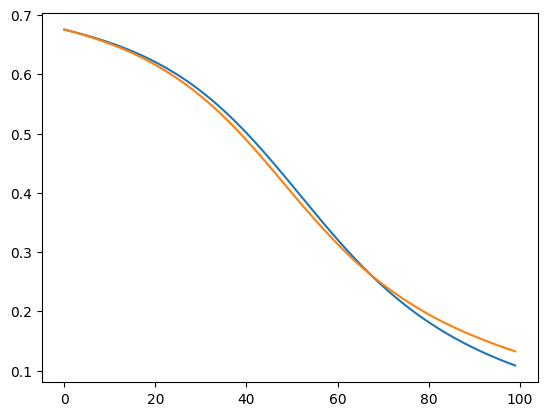

In [ ]:
#Plotting the Loss Curve
plt.plot(training_loss,label="Training Loss")
plt.plot(testing_loss,label="Testing Loss")


In [ ]:
#Creating a Random Forest Classifier for comparison
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
print(Accuracy(y_test,torch.tensor(rf_pred)))
#evaluate the rf
print(rf.predict(X_test[5].reshape(1,-1)))
y_test[5]

100.0
[1.]


tensor(1.)